## Prototype for Conformalized Survival Analysis with Right-Censoring

This notebook demonstrates the performance of a new prototype method to calibrate lower confidence bounds for survival times under right-censoring.
This method used imputation of unobserved censoring times to obtain an artificial data set with type-I censoring, and then applies Candes' method.
The methods are implemented in the accompanying "utils" R scripts.

In [1]:
# Load required libraries
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))
library(survival)
library(ggsurvfit)
library(grf)
library(cfsurvival)

## Generate some survival data

In [2]:
# Generate data from the Log-normal model (Mvt + Heterosc.) of Candes et al. (Table 1)
source("utils_data_new.R")

# Numbers of features (>= 10)
num_features <- 10

# Create an instance of SurvivalDataGenerator
# Supported models:
generator <- LogNormalSurvivalGenerator$new(num_features = num_features)
#generator <- WeibullSurvivalGenerator$new(num_features = num_features)

# Sample sizes
num_samples_train <- 200
num_samples_cal <- 200
num_samples_test <- 500


# Set random seet
set.seed(2024)

# Generate training, calibration, and test data
# (including true event and censoring times)
data.train.oracle <- generator$sample_survival_data(num_samples_train)
data.cal.oracle <- generator$sample_survival_data(num_samples_cal)
data.test.oracle <- generator$sample_survival_data(num_samples_test)

# Remove true event and censoring times from the data (right-censoring)
data.train <- data.train.oracle |> select(-event_time, -censoring_time)
data.cal <- data.cal.oracle |> select(-event_time, -censoring_time)
data.test <- data.test.oracle |> select(-event_time, -censoring_time)

# Remove only true event times from the data (type-I censoring)
data.train.t1 <- data.train.oracle |> select(-event_time)
data.cal.t1 <- data.cal.oracle |> select(-event_time)
data.test.t1 <- data.test.oracle |> select(-event_time)

#generator$predict_quantiles(select(data.test, -time, -status)[c(24),], T.max=1000)

In [3]:
source("utils_conformal.R")

alpha = 0.1

pred.oracle <- generator$predict_quantiles(select(data.test, -time, -status), probs=c(alpha), T.max=1000)[[1]]

evaluate_bounds(data.test$time, 
                pred.oracle,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Median lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>,<dbl>
0.746,5.591253,5.276203,0.908


Let's take a look at the data

In [4]:
# Summarize data under type-I censoring
data.train.oracle |>
    summarise(Observations=n(), Events = sum(status), 
              `Median event time`=median(event_time),
              `Mean event time`=mean(event_time),
              `Median censoring time`=median(censoring_time),
              `Mean censoring time`=mean(censoring_time),
              `Median observed time`=median(time),
              `Median observed event time`=median(time[status]),
              `Median censoring time` = median(censoring_time))

Observations,Events,Median event time,Mean event time,Median censoring time,Mean censoring time,Median observed time,Median observed event time
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
200,166,6.411823,6.964865,22.32247,117.8293,6.284225,6.923696


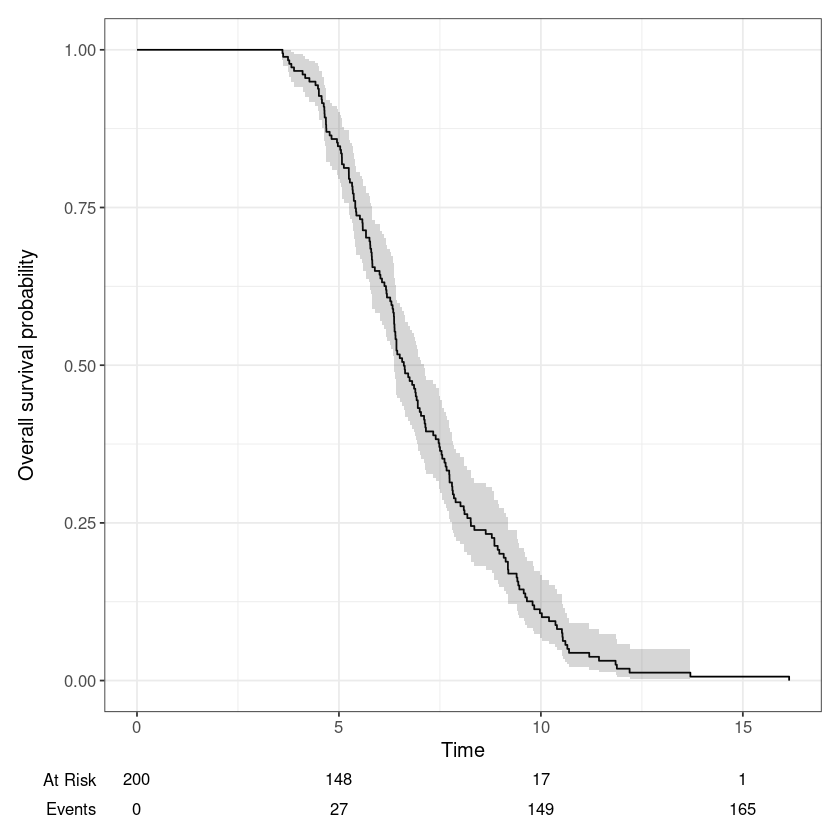

In [5]:
# Kaplan-Meier plot
survfit2(Surv(time, status) ~ 1, data = data.train) |> 
  ggsurvfit() +
  labs(
    x = "Time",
    y = "Overall survival probability"
  ) +
  add_confidence_interval() +
  add_risktable()

Compare true event and censoring times.

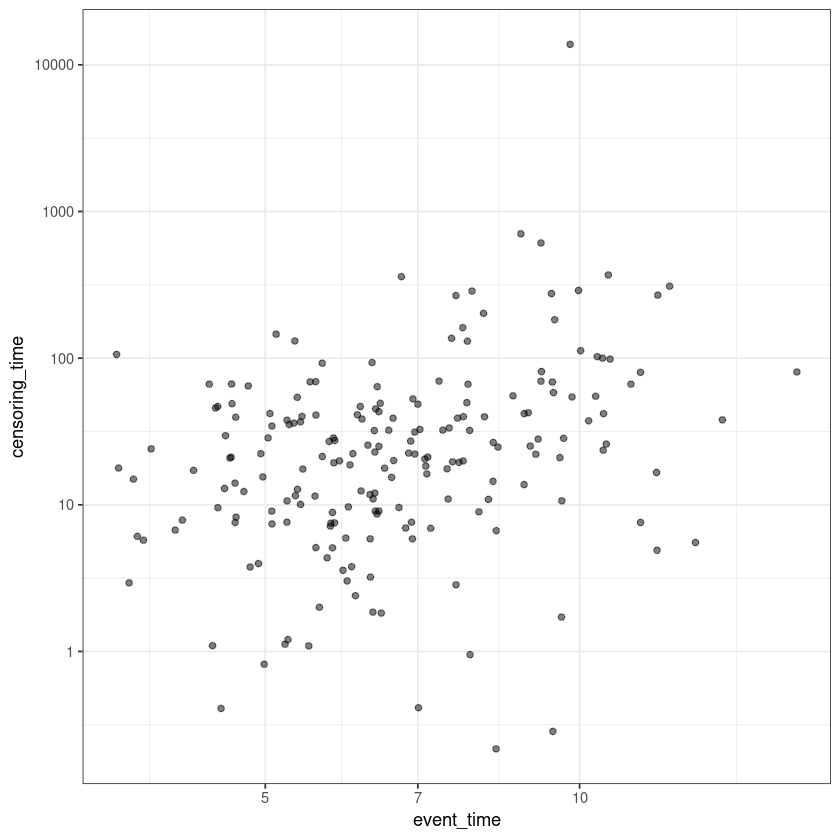

In [6]:
data.train.oracle |>
    ggplot(aes(x=event_time, y=censoring_time)) +
    geom_point(alpha=0.5) +
    scale_y_continuous(trans='log10') +
    scale_x_continuous(trans='log10') +
    theme_bw()

## Fit survival model

Fit a survival model using the training data.

In [7]:
source("utils_survival_new.R")

model_type = "grf"

if(model_type=="grf") {
    # Instantiate GRF survival forest
    surv_model <- GRF_SurvivalForestWrapper$new()
} else if (model_type=="survreg") {
    # Instantiate Cox proportional hazards model
    surv_model <- SurvregModelWrapper$new(dist="weibull")
} else if (model_type=="rf") {
    # Instantiate random forest survival model
    surv_model <- randomForestSRC_SurvivalWrapper$new()
} else {
    stop("Unknown model type!")
}

# Fit the survival model
surv_model$fit(Surv(time, status) ~ ., data = data.train)

## Visualize the model's predictions

Visualize the predicted survival curves for two individuals.

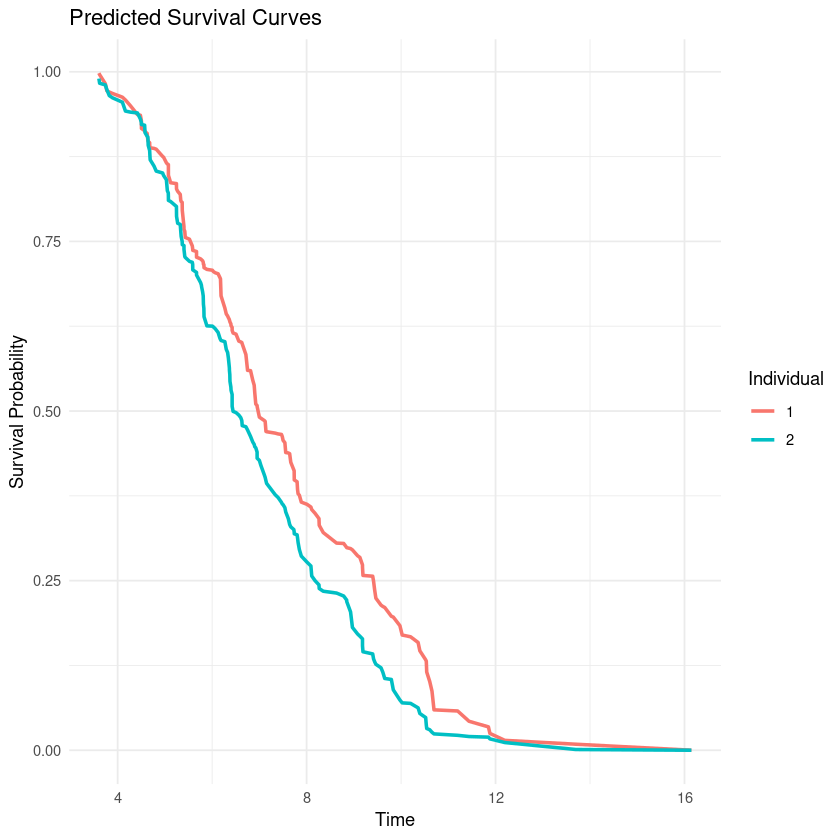

In [8]:
source("utils_plotting_new.R")

idx.predict <- c(1,2)

plot_survival_curves(surv_model, new_data = data.cal[idx.predict,])

Predict survival time quantiles

In [9]:
# Predict survival time quantiles
surv_model$predict_quantiles(data.cal[idx.predict,], probs = c(0.1, 0.5, 0.9))

,Q10%,Q50%,Q90%
,<dbl>,<dbl>,<dbl>
Individual_1,4.637945,6.999801,10.654442
Individual_2,4.646560,6.443807,9.835383


## Estimating the censoring distribution

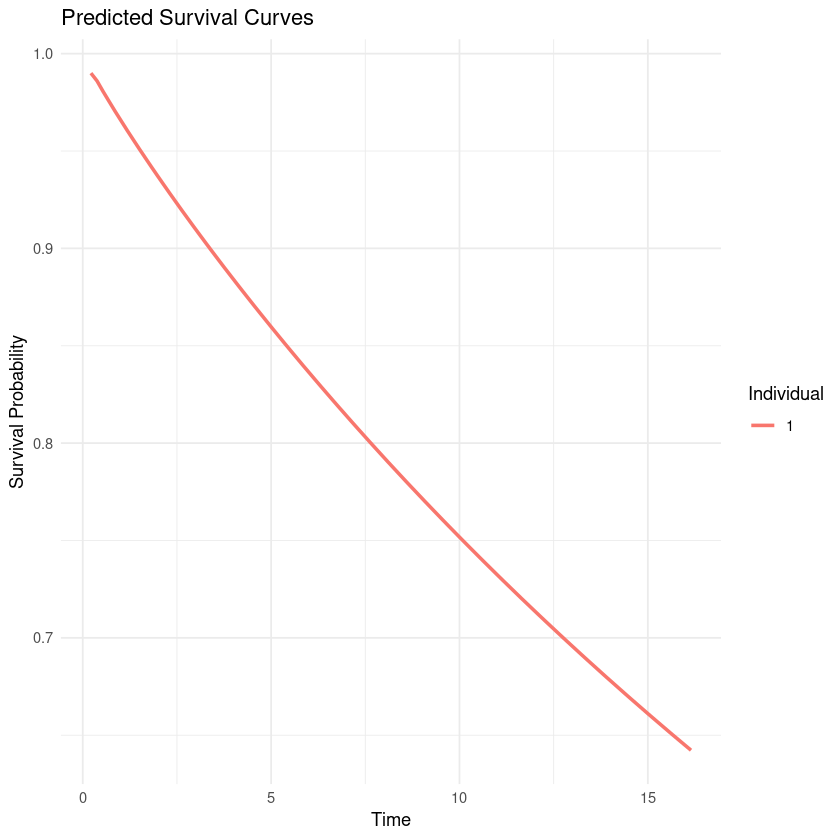

In [10]:
source("utils_censoring.R")

# Initialize a base model for the censoring distribution
cens_base_model <- SurvregModelWrapper$new(dist="weibull")

# Create an instance of the CensoringModel class with the model
censoring_model <- CensoringModel$new(model = cens_base_model)

# Fit the censoring distribution
censoring_model$fit(data = data.train)

# Plot the censoring distribution for the first individual
idx.predict <- c(1)
plot_survival_curves(censoring_model$model, new_data = data.cal[idx.predict,])

In [11]:
# Re-sample the censoring times
idx.predict <- c(1)

C.new <- sapply(1:20, function(i) {censoring_model$sample_censoring_times(data.cal[idx.predict,], T=data.cal$time[idx.predict])})

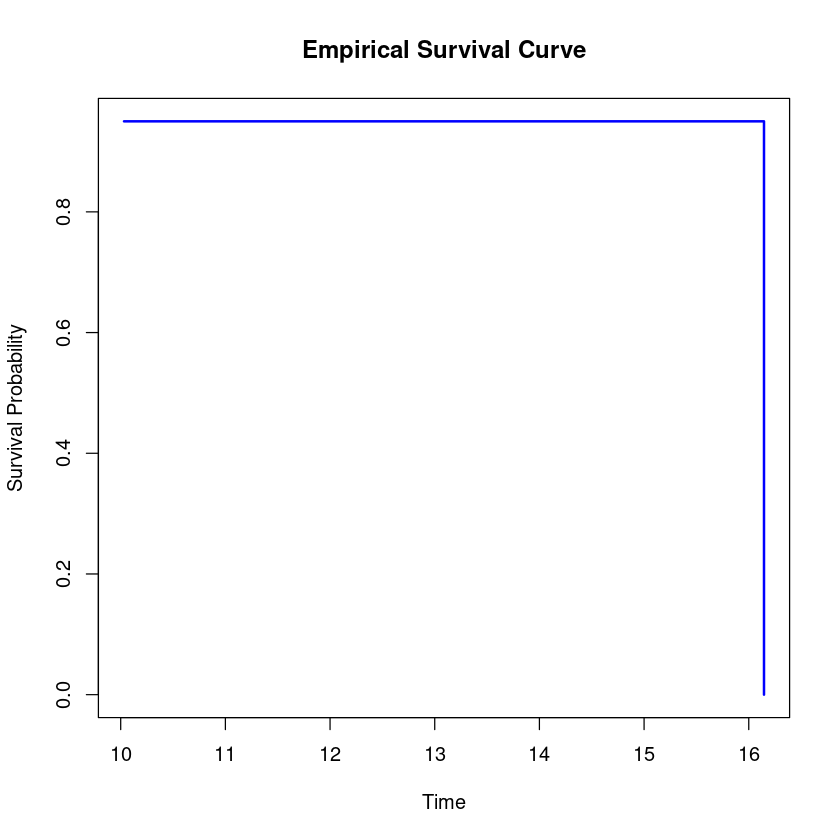

In [12]:
plot_empirical_survival_curve <- function(values) {
  # Remove NA values
  values <- na.omit(values)
    
  # Sort the input values
  sorted_times <- sort(values)
  
  # Calculate the empirical survival probabilities (1 - ECDF)
  n <- length(values)
  empirical_cdf <- (1:n) / n
  survival_probabilities <- 1 - empirical_cdf
  
  # Plot the empirical survival curve
  plot(sorted_times, survival_probabilities, type = "s", 
       xlab = "Time", ylab = "Survival Probability", 
       main = "Empirical Survival Curve", col = "blue", lwd = 2)
}

plot_empirical_survival_curve(C.new)

## Oracle prediction bounds

In [13]:
source("utils_conformal.R")

alpha = 0.1

pred.oracle <- generator$predict_quantiles(select(data.test, -time, -status), probs=c(alpha), T.max=10000)[[1]]

evaluate_bounds(data.test$time, 
                pred.oracle,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Median lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>,<dbl>
0.746,5.591258,5.276203,0.908


## Naive CQR

In [14]:
source("utils_conformal.R")

alpha = 0.1
pred.cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

evaluate_bounds(data.test$time, 
                pred.cqr$calibrated,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Median lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>,<dbl>
0.882,3.11445,3.010813,0.998


## Nominal lower bound

In [15]:
alpha = 0.1
pred.nominal <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]

evaluate_bounds(data.test$time, 
                pred.nominal,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Median lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>,<dbl>
0.77,4.667665,4.64183,0.91


## CQR with de-censoring

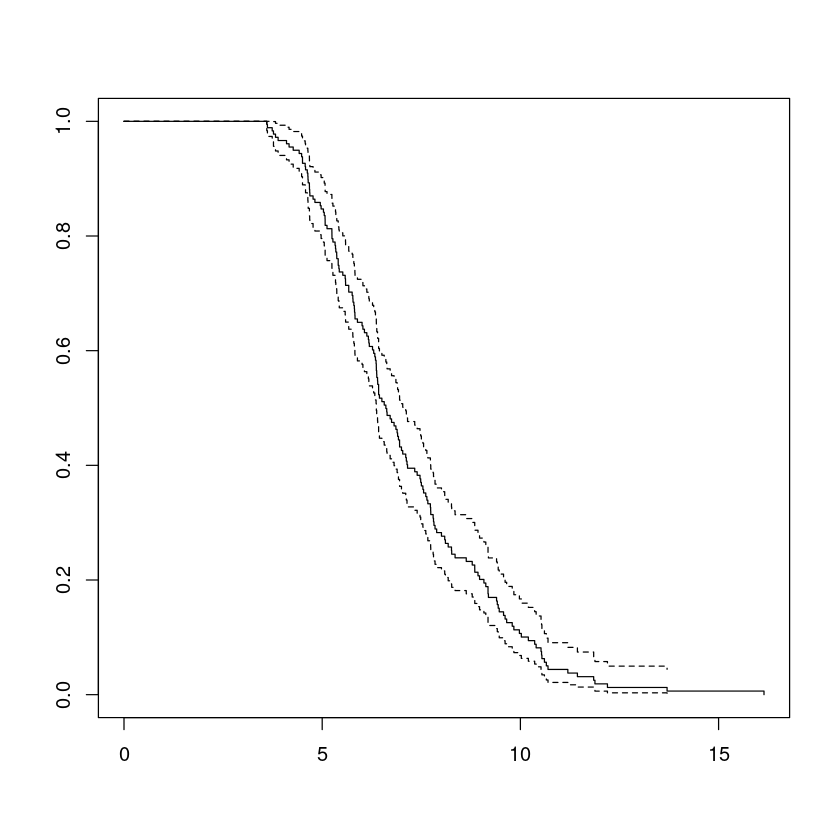

In [16]:
## Create a survival object
surv_object <- survival::Surv(time = data.train$time, event = data.train$status)

## Fit the Kaplan-Meier survival model
km_fit <- survfit(surv_object ~ 1)

## Plot the Kaplan-Meier survival curve
plot(km_fit)

In [17]:
source("utils_decensoring.R")

pred.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)

evaluate_bounds(data.test.oracle$time, 
                pred.decensor$calibrated,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Median lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>,<dbl>
0.786,4.5923,4.488662,0.92


## Candes' method (with oracle censoring times, and oracle weights)

In [18]:
source("utils_conformal.R")

# Impute the missing censoring times
C.cal <- data.cal.oracle$censoring_time

pred.candes <- predict_Candes(data.test, surv_model, generator, data.cal, C.cal, alpha)

evaluate_bounds(data.test.oracle$time, 
                pred.candes$calibrated,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Median lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>,<dbl>
0.804,4.423544,4.31458,0.938


## Candes' method (with oracle censoring times, and estimated weights)

In [19]:
source("utils_conformal.R")

# Impute the missing censoring times
C.cal <- data.cal.oracle$censoring_time

# Create an instance of the CensoringDistribution class with the model
cens_base_model <- SurvregModelWrapper$new(dist="weibull")

# Create an instance of the CensoringModel class with the model
cens_model <- CensoringModel$new(model = cens_base_model)

# Fit the censoring model on the training data
cens_model$fit(data = data.train)

pred.candes <- predict_Candes(data.test, surv_model, cens_model$model, data.cal, C.cal, alpha)

evaluate_bounds(data.test.oracle$time, 
                pred.candes$calibrated,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Median lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>,<dbl>
0.804,4.418145,4.31458,0.938


## Prototype (with Candes' method, imputation based on estimated censoring model, estimated weights)

In [20]:
source("utils_conformal.R")

pred.proto <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha)

evaluate_bounds(data.test$time, 
                pred.proto$calibrated,
                event_time=data.test.oracle$event_time)

Coverage (observed time),Mean lower bound,Median lower bound,Coverage (event time)
<dbl>,<dbl>,<dbl>,<dbl>
0.79,4.574662,4.471255,0.92


## Repeated experiments

In [21]:
surv_model <- GRF_SurvivalForestWrapper$new()
cens_base_model <- SurvregModelWrapper$new(dist="weibull")

analyze_data <- function(data.train, data.cal, data.test, 
                         surv_model, cens_model, generator=NULL) {
    
    # Fit the survival model on the training data
    surv_model$fit(Surv(time, status) ~ ., data = data.train)
    
    # Fit the censoring model on the training data
    cens_model <- CensoringModel$new(model = cens_base_model)
    cens_model$fit(data = data.train)
    
    # Apply all methods
    predictions <- c()
    
    # Construct oracle lower bound
    if(!is.null(generator)) {
        pred.oracle <- generator$predict_quantiles(select(data.test, -time, -status), probs=c(alpha), T.max=1000)[[1]]
        predictions$oracle <- c()
        predictions$oracle$uncalibrated <- pred.oracle
        predictions$oracle$calibrated <- pred.oracle
    }
    
    # Construct nominal lower bound
    pred.nominal <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]
    predictions$nominal <- c()
    predictions$nominal$uncalibrated <- pred.nominal
    predictions$nominal$calibrated <- pred.nominal
    
    # Apply naive CQR
    predictions$cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

    # Apply CQR with de-censoring
    predictions$cqr.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)
    
    # Apply Candes' method with "oracle" censoring model
    C.cal.oracle <- data.cal.oracle$censoring_time
    predictions$candes.oracle <- predict_Candes(data.test, surv_model, generator, data.cal, C.cal.oracle, alpha)

    # Apply prototype
    predictions$prototype <- predict_prototype(data.test, surv_model, cens_model, data.cal, alpha)
   
    return(predictions)
}

predictions <- analyze_data(data.train, data.cal, data.test, surv_model, cens_model, generator=generator)

In [22]:
results <- do.call(rbind, lapply(names(predictions), function(name) {
    res = evaluate_bounds(data.test$time, 
                predictions[[name]]$calibrated,
                event_time=data.test.oracle$event_time)
    
  cbind(Method = name, res)
}))
results

Method,Coverage (observed time),Mean lower bound,Median lower bound,Coverage (event time)
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
oracle,0.746,5.591253,5.276203,0.908
nominal,0.770,4.663609,4.637945,0.910
cqr,0.878,3.261519,3.178096,0.996
cqr.decensor,0.790,4.593657,4.510235,0.920
candes.oracle,0.794,4.545711,4.461360,0.924
prototype,0.800,4.502295,4.447140,0.930


## TODO

 - Design more interesting data distribution
 - Run large-scale experiments